In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy.stats
import scipy.optimize
import scipy.integrate
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
np.random.seed(100)

n_patients_per_group = 50
n_arms = 4
n_sims = 1000

# The group effects are drawn from a distribution with mean 0.5 and variance 1.0
mean_effect = 0.5
effect_var = 1.0
t_i = scipy.stats.norm.rvs(mean_effect, np.sqrt(effect_var), size=(n_sims, n_arms))

# inverse logit to get probabilities from linear predictors.
p_i = scipy.special.expit(t_i)

n_i = np.full_like(p_i, n_patients_per_group)

# draw actual trial results.
y_i = scipy.stats.binom.rvs(n_patients_per_group, p_i)
y_i.shape

(1000, 4)

## INLA

In [5]:
%%time
import model
post_theta, logpost_theta_data = model.calc_posterior_theta(y_i, n_i)

CPU times: user 415 ms, sys: 109 ms, total: 524 ms
Wall time: 525 ms


In [5]:
%%time
mu_post, sigma_post = model.calc_posterior_x(post_theta, logpost_theta_data)

CPU times: user 9.81 ms, sys: 6.45 ms, total: 16.3 ms
Wall time: 15.6 ms


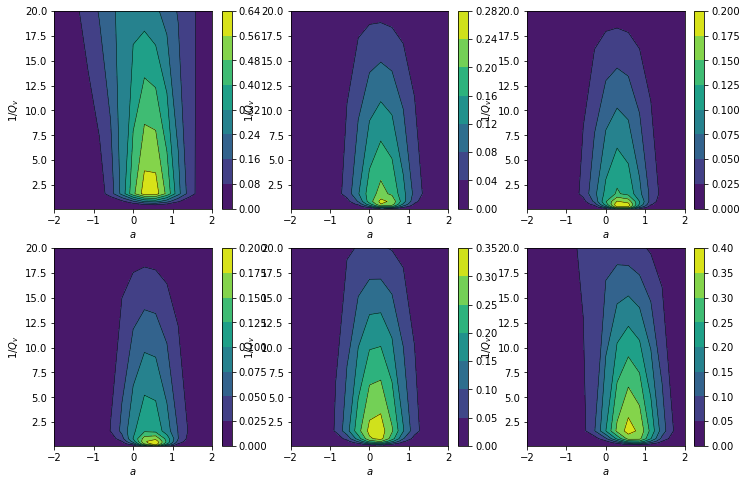

In [6]:
a_grid = logpost_theta_data['a_grid']
q_grid = logpost_theta_data['q_grid']
plt.figure(figsize=(12, 8))
for i in range(6):
    field = post_theta[i]
    levels = None
    plt.subplot(2, 3, i+1)
    cntf = plt.contourf(a_grid, 1/q_grid, field.reshape(a_grid.shape), levels=levels)
    plt.contour(
        a_grid, 1/q_grid, field.reshape(a_grid.shape),
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels
    )
    cbar = plt.colorbar(cntf)
    plt.xlabel('$a$')
    plt.ylabel('$1/Q_v$')
plt.show()

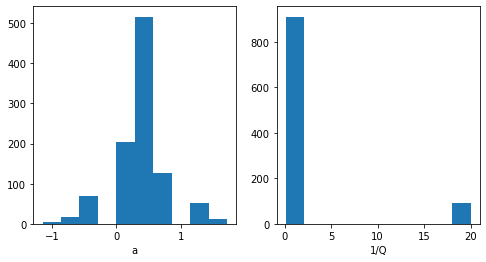

In [7]:
map_idx = np.argmax(post_theta.reshape((n_sims, -1)), axis=1)
map_A = a_grid.ravel()[map_idx]
map_Q = q_grid.ravel()[map_idx]
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.hist(map_A)
plt.xlabel('a')
plt.subplot(1,2,2)
plt.hist(1 / map_Q)
plt.xlabel('1/Q')
plt.show()

In [8]:
ci025 = mu_post - 1.96 * sigma_post
ci975 = mu_post + 1.96 * sigma_post
good = (ci025 < t_i) & (t_i < ci975)
np.sum(good) / (n_sims * n_arms)

0.9465

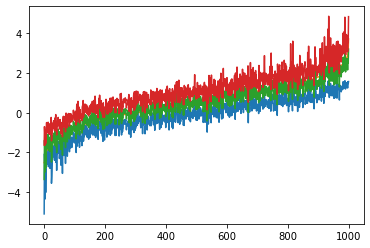

In [9]:
sorted_idxs = np.argsort(t_i[:,0])
plt.plot(ci025[sorted_idxs, 0])
plt.plot(t_i[sorted_idxs, 0])
plt.plot(mu_post[sorted_idxs, 0])
plt.plot(ci975[sorted_idxs, 0])
plt.show()

## MCMC

In [11]:
%%time
from model import mcmc
mcmc_results = mcmc(y_i, n_i, iterations=50000, burn_in=500, skip=3)
assert np.all(
    (mcmc_results["CI025"] < mcmc_results["mean"])
    & (mcmc_results["mean"] < mcmc_results["CI975"])
)

CPU times: user 33.9 s, sys: 1.02 s, total: 34.9 s
Wall time: 35 s


In [12]:
print('mcmc results')
effect_estimates_in_cis = (mcmc_results["CI025"][:, :4] < t_i) & (
    t_i < mcmc_results["CI975"][:, :4]
)
mean_est_in_cis = (mcmc_results["CI025"][:, 4] < mean_effect) & (
    mean_effect < mcmc_results["CI975"][:, 4]
)
var_est_in_cis = (mcmc_results["CI025"][:, 5] < effect_var) & (
    effect_var < mcmc_results["CI975"][:, 5]
)
np.sum(effect_estimates_in_cis) / (n_sims * n_arms), np.sum(mean_est_in_cis) / (
    n_sims
), np.sum(var_est_in_cis) / (n_sims)


mcmc results


(0.94475, 0.954, 0.961)

# Profiling MCMC to understand the slow parts

In [19]:
%load_ext line_profiler
from model import proposal, calc_log_joint, calc_log_prior
%lprun -f mcmc -f proposal -f calc_log_joint -f calc_log_prior mcmc(y_i, n_i, iterations=10000, burn_in=500, skip=3)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
79 3087


Timer unit: 1e-06 s

Total time: 2.3494 s
File: /Users/tbent/Dropbox/active/fda/kevlar/inla_explore/model.py
Function: calc_log_prior at line 21

Line #      Hits         Time  Per Hit   % Time  Line Contents
    21                                           def calc_log_prior(a, Qv):
    22     10001    2349397.0    234.9    100.0      return scipy.stats.norm.logpdf(a, 0, 1) + scipy.stats.lognorm.logpdf(Qv, 10.0)

Total time: 3.67178 s
File: /Users/tbent/Dropbox/active/fda/kevlar/inla_explore/model.py
Function: calc_log_joint at line 25

Line #      Hits         Time  Per Hit   % Time  Line Contents
    25                                           def calc_log_joint(x, y, n, a, Qv):
    26     10001     204620.0     20.5      5.6      Q = calc_precision_matrixQ(y.shape[1], Qv)
    27     10001     276590.0     27.7      7.5      term1 = -np.sum(((x - a[:, None]) ** 2) * Q, axis=1) / 2
    28     10001     662942.0     66.3     18.1      term2 = np.sum(x * y - n * np.log(np.exp(x) + 1),